# The Method

In [1]:
!pip install activeSVC==4.0.1
!pip install psutil

In [7]:
import numpy as np
import time
import random
import os

from sklearn.preprocessing import normalize 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import gridspec

from activeSVC import min_complexity, min_acquisition,min_complexity_cv, min_acquisition_cv
import pandas as pd
import pickle
import os, psutil
import resource


def text_create(path, name, msg):
    full_path = path + "/" + name + '.pickle'
    f=open(full_path,'wb') 
    pickle.dump(msg,f)
    f.close()

class TimerError(Exception):
     """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Total run time: {elapsed_time:0.4f} seconds")
        return elapsed_time
        




# Download and Load PBMC Data

In [3]:
import urllib.request
import shutil

try:
    os.mkdir('data')
except OSError:
    print ("Creation of the directory %s failed" % 'data')
else:
    print ("Successfully created the directory %s " % 'data')
    
with urllib.request.urlopen("https://caltech.box.com/shared/static/wqvm0d9irzb7tneb16q01fnr4dt6cvl0.csv") as response, open('./data/PBMCnorm_final.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)

with urllib.request.urlopen("https://caltech.box.com/shared/static/mxnl3tu0p8ta6zehdutjg8vxpppv3t8v.csv") as response, open('./data/labels_final.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)

with urllib.request.urlopen("https://caltech.box.com/shared/static/mysl5kjfq6p87ib7zygrpc61b8jyxt3g.csv") as response, open('./data/genes_final.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)


In [4]:
data_df = pd.read_csv('./data/PBMCnorm_final.csv')
label_df=pd.read_csv('./data/labels_final.csv',header = None)
gene_df=pd.read_csv('./data/genes_final.csv')
classes=[0,1,2,3,4]
keys=['Monocytes','T cells','Act. T/NK','B cells','Others']

raw_data=data_df.values
target=label_df.values.reshape((raw_data.shape[1],)).astype(np.uint8)-1
gene=gene_df.values.reshape((raw_data.shape[0],))
data=normalize(np.transpose(raw_data),axis=1, norm='l2')
del data_df,label_df,gene_df,raw_data


idx = np.arange(np.shape(data)[0])
random.shuffle(idx)
X_train = data[idx[:int(np.shape(data)[0]*4/5)],:]
y_train = target[idx[:int(np.shape(data)[0]*4/5)]]
X_test = data[idx[int(np.shape(data)[0]*4/5):],:]
y_test = target[idx[int(np.shape(data)[0]*4/5):]]

print(type(data))
print(np.shape(data),np.shape(target),len(np.unique(target)))
print(np.shape(X_train))
print(np.shape(X_test))
for i in np.unique(target):
    print('class '+keys[i]+': '+str(np.count_nonzero((target==i)*1)))

<class 'numpy.ndarray'>
(10194, 6915) (10194,) 5
(8155, 6915)
(2039, 6915)
class Monocytes: 3269
class T cells: 3517
class Act. T/NK: 1265
class B cells: 995
class Others: 1148


# min_complexity

## Define Parameters and Work Space

In [9]:
'''
Parameters
'''
num_features = 10
num_samples=20
init_samples=100
balance=False

folder='results/min_complexity'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory results failed
Creation of the directory results/min_complexity failed
Successfully created the directory results/min_complexity/test_10_20 


## Select Genes and Save Results

Elapsed time: 217.0543 seconds
feature 1 : gene [3702]  100 samples
training error=2.04659717964439 test error=2.262873957822462
training accuracy=0.6375229920294297 test accuracy=0.6307013241785189
Elapsed time: 192.1954 seconds
feature 2 : gene 882  120 samples
training error=1.623421213979154 test error=1.7910740559097598
training accuracy=0.6984671980380135 test accuracy=0.6944580676802354
Elapsed time: 192.9070 seconds
feature 3 : gene 455  139 samples
training error=1.596811771919068 test error=1.7851888180480628
training accuracy=0.699202942979767 test accuracy=0.6959293771456596
Elapsed time: 189.7626 seconds
feature 4 : gene 3893  159 samples
training error=1.5594114040465972 test error=1.754291319274154
training accuracy=0.7253218884120172 test accuracy=0.7155468366846494
Elapsed time: 190.1753 seconds
feature 5 : gene 4204  179 samples
training error=1.4305334150827713 test error=1.660617949975478
training accuracy=0.7459227467811159 test accuracy=0.7385973516429623
Elapsed 

流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_classes.py", line 272, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 1147, in _fit_liblinear
    % classes_[0]
ValueError: This solver needs samples of at least 2 c

Elapsed time: 204.0567 seconds
feature 9 : gene 2501  254 samples
training error=1.2275904353157572 test error=1.4811181951937225
training accuracy=0.8377682403433476 test accuracy=0.8141245708680726


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_classes.py", line 272, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 1147, in _fit_liblinear
    % classes_[0]
ValueError: This solver needs samples of at least 2 classes in the data, but the

Elapsed time: 193.3810 seconds
feature 10 : gene 865  273 samples
training error=1.1977927651747393 test error=1.4325649828347229
training accuracy=0.841937461679951 test accuracy=0.8200098087297695
Total run time: 1958.5519 seconds


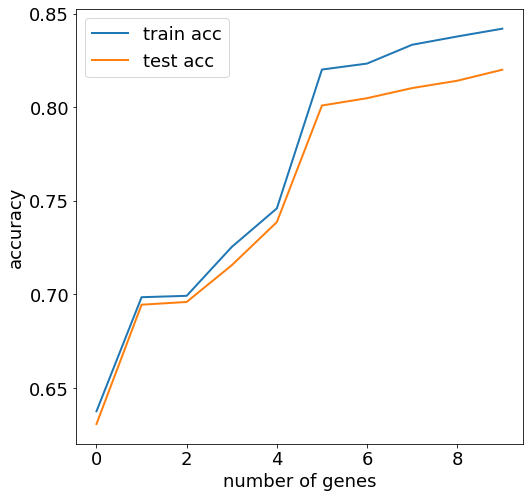

In [10]:
'''
Sometimes it shows ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
This is because of the settings of algorithm. 
Please set a larger num_samples and init_samples and then re-run this cell. 
Or set parameter class_weight='balanced' and balance=True and then re-run the cell. 
'''
if __name__ == '__main__':

    t=Timer()
    t.start()
    feature_selected, num_samples_list, train_errors,test_errors,train_scores,test_scores,paras,step_times= min_complexity_cv(
        X_train,y_train,X_test,y_test,num_features=num_features,num_samples=num_samples,init_features=1,init_samples=init_samples, balance=balance,
        tol=[1e-1,1e-2,1e-3],C=[0.01,0.1,1],n_splits=3, max_iter=1000)
    elapsed_time=t.stop()
    
    memorys=[]
    memorys.append(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
    memorys.append(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/ 1024 ** 2)
    
    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'genes_name',gene[feature_selected])
    text_create(path,'elapsed_time',elapsed_time)
    text_create(path,'memory',memorys)

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

# min_aquisition

## Define Parameters and Work Space

In [11]:
'''
Parameters
'''
num_features = 10
num_samples=100
init_samples=200

folder='results/min_acquisition'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory results failed
Successfully created the directory results/min_acquisition 
Successfully created the directory results/min_acquisition/test_10_100 


## Select Genes and Save Results

Elapsed time: 224.7372 seconds
feature 0 : gene [3893]  200 samples
training error=2.3823421213979152 test error=2.584600294261893
training accuracy=0.645003065603924 test accuracy=0.640019617459539
Elapsed time: 248.3885 seconds
feature 1 : gene 452  231 samples
training error=1.6521152667075414 test error=1.8504168710152036
training accuracy=0.7031269160024525 test accuracy=0.7037763609612555
Elapsed time: 267.4403 seconds
feature 2 : gene 1829  249 samples
training error=1.6453709380748007 test error=1.8489455615497794
training accuracy=0.7297363580625383 test accuracy=0.7317312408043158
Elapsed time: 269.8551 seconds
feature 3 : gene 6203  262 samples
training error=1.5337829552421827 test error=1.719960765080922
training accuracy=0.8026977314530963 test accuracy=0.7940166748406081
Elapsed time: 294.3020 seconds
feature 4 : gene 2025  290 samples
training error=1.5275291232372779 test error=1.760176557135851
training accuracy=0.8163090128755365 test accuracy=0.801863658656204
Elaps

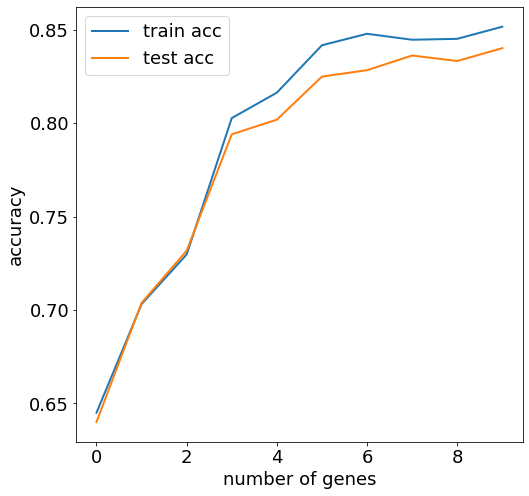

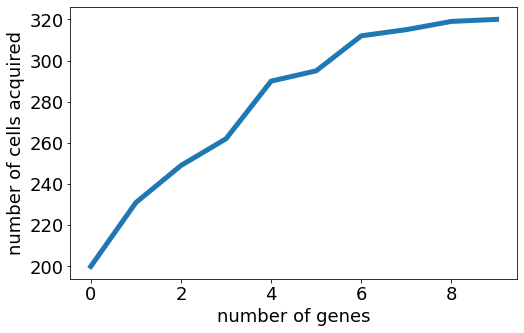

In [12]:
'''
Sometimes it shows ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
This is because of the settings of algorithm. 
Please set a larger num_samples and init_samples and then re-run this cell. 
Or set parameter class_weight='balanced' and balance=True and then re-run the cell. 
'''
if __name__ == '__main__':

    t=Timer()
    t.start()
    feature_selected, num_samples_list, samples_global, train_errors,test_errors,train_scores,test_scores,paras,step_times= min_acquisition_cv(
        X_train,y_train,X_test,y_test,num_features=num_features,num_samples=num_samples,init_features=1,init_samples=init_samples,balance=balance, 
        tol=[1e-1,1e-2,1e-3],C=[0.01,0.1,1],n_splits=3, max_iter=1000)
    elapsed_time=t.stop()
    
    memorys=[]
    memorys.append(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
    memorys.append(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/ 1024 ** 2)
    
    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'samples_global',samples_global)
    text_create(path,'genes_name',gene[feature_selected])
    text_create(path,'elapsed_time',elapsed_time)
    text_create(path,'memory',memorys)

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

    plt.figure(figsize=(8,5))
    plt.plot(num_samples_list,linewidth=5)
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('number of cells acquired',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/cells.pdf', bbox_inches="tight")

# T-SNE of Results

## T-SNE of Original Dataset

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


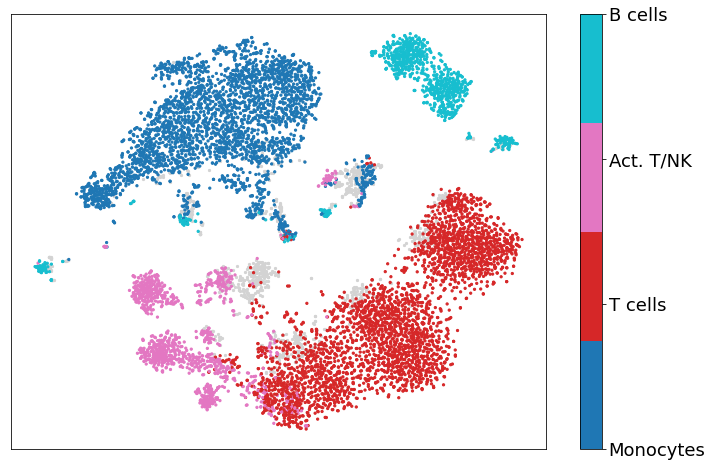

In [13]:
plt.figure(figsize=(12,8))

pca=PCA(n_components=int(X_train.shape[1]/100),
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data)

Y=TSNE(n_components=2).fit_transform(pcaproj)

others=list(np.where(target==4)[0])
cells=list(np.where(target!=4)[0])

c_cmap = plt.get_cmap('tab10', len(classes)-1)
plt.scatter(Y[others,0], Y[others,1], c='lightgray', s=5)
plt.scatter(Y[cells,0],Y[cells,1],c=target[cells],s=5,cmap=c_cmap)
cbar=plt.colorbar(ticks=np.arange(len(classes)-1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys[:-1],fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne.pdf',bbox_inches="tight")

f=open(path+'/tsne.pickle','wb') 
pickle.dump(Y,f)
f.close()

## T-SNE with All Genes Selected

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


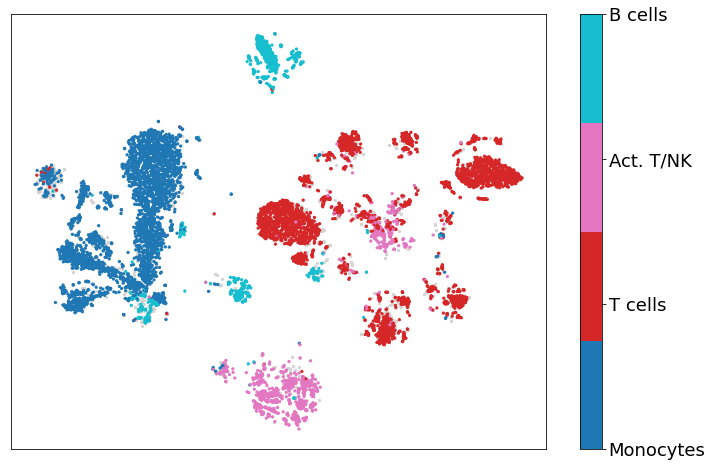

In [14]:
plt.figure(figsize=(12,8))
data_selected=data[:,feature_selected]

pca=PCA(n_components=7,
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data_selected)

Y_selected=TSNE(n_components=2,perplexity=200,early_exaggeration=1).fit_transform(pcaproj)

others=list(np.where(target==4)[0])
cells=list(np.where(target!=4)[0])

c_cmap = plt.get_cmap('tab10', len(classes)-1)
plt.scatter(Y_selected[others,0], Y_selected[others,1], c='lightgray', s=5)
plt.scatter(Y_selected[cells,0],Y_selected[cells,1],c=target[cells],s=5,cmap=c_cmap)
cbar=plt.colorbar(ticks=np.arange(len(classes)-1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys[:-1],fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne_selected_wPCA.pdf',bbox_inches="tight")

f=open(path+'/tsne_selected_wPCA.pickle','wb') 
pickle.dump(Y_selected,f)
f.close()

## T-SNE of Each Gene

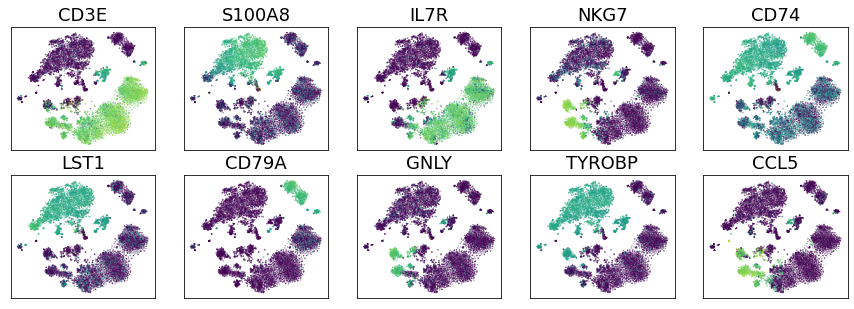

In [15]:
alpha = 100
data_show = np.log1p(data*alpha)

size=len(feature_selected)
plt.figure(figsize=(15,2.5*int(size/5)))
gs = gridspec.GridSpec(int(size/5), 5, width_ratios=[7,7,7,7,7])

for i in range(size):
    f=feature_selected[i]
    ax0 = plt.subplot(gs[i])
    ax0.set_title(gene[f],fontdict={'weight':'normal','size': 18})
    plt.scatter(Y[:,0],Y[:,1],c=data_show[:,f],s=0.05)
    ax0.set_xticks([])
    ax0.set_yticks([])
plt.savefig(path+'/gene.png',dpi=300,  bbox_inches="tight")    